# SAT Solving for C1 Methods

This is a notebook for Appendix A of the paper "An approach to generalizing some impossibility theorems in social choice" by Wesley H. Holliday, Eric Pacuit, and Saam Zahedian.  


We use a SAT solver to prove that anonymity, neutrality, binary quasi-resoluteness,  binary $\gamma$, and $\alpha$-resoluteness are inconsistent.

## Notebook Overview

1. **Canonical (weak) tournament solutions** 
    1. Canonical (weak) tournaments
    2. Orbit condition
    
2. **SAT setup**
    1. Winning set dictionary
    2. Functionality

3. **Binary quasi-resoluteness**

4. **Tournament embeddings**
    1. Tournament embedding example
    2. Generate canonical (weak) tournament embeddings
    
5. **Binary $\gamma$**

6. **$\alpha$-resoluteness**

7. **Demonstration of Theorem A.12**
    1. Demonstration of Theorem A.12.1
    2. Demonstration of Theorem A.12.2
    

In [1]:
from itertools import product, combinations, chain
import pickle
import networkx as nx # for graphs
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3 # SAT solver

In [2]:
# helper functions

def display_wt(wt):
    """Display a (weak) tournament"""
    pos = nx.circular_layout(wt)
    nx.draw(wt, pos, font_size=20, node_color='blue', font_color='white', 
            node_size = 700, width=1, with_labels=True)
    plt.show()

def is_maj_preferred(wt, c1, c2): 
    """True if c1 is majority preferred to c2"""
    return wt.has_edge(c1, c2)

def is_tournament(wt):
    """test if a weak tournament is a tournament"""
    candidates = wt.nodes
    is_t = True
    for c1 in candidates: 
        for c2 in candidates: 
            if c1 != c2 and not is_maj_preferred(wt,c1,c2) and not is_maj_preferred(wt,c2,c1):
                is_t = False
    return is_t

def findsubsets(s, n):
    """all subsets of the list s of size n""" 
    return [set(i) for i in combinations(s, n)] 

def powerset_ne(fullset):
    """return all non-empty subsets of fullset"""
    listrep = list(fullset)
    n = len(listrep)
    all_subsets = [[listrep[k] for k in range(n) if i&1<<k ] for i in range(2**n)]
    return [sorted(s) for s in all_subsets if len(s) > 0]

def all_included(listlike, items):
    """
    helper for powerset_ne_plus
    returns true if all members of items are in listlike
    """
    for item in items:
        if item not in listlike:
            return False
    return True

def powerset_ne_plus(listlike, items):
    """returns all non-empty subsets of setlike which include elements of items"""
    return [sorted(pset) for pset in powerset_ne(listlike) if all_included(pset, items)]


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def concat(ls): 
    return list(chain.from_iterable(ls))


## 1. Canonical (weak) tournaments solutions

### A. Canonical (weak) tournaments

To see how the canonical (weak) tournaments are generated, see the notebook Canonical_Tournaments.ipynb.

In [3]:
# Only consider tournaments up to six candidates
numbers_of_candidates = [2, 3, 4, 5, 6]

# Paths to pickled weak tournaments
canonical_weak_tournament_paths = {
    2: 'weak_tourns/weak_tourns_2.pkl',
    3: 'weak_tourns/weak_tourns_3.pkl',
    4: 'weak_tourns/weak_tourns_4.pkl',
    5: 'weak_tourns/weak_tourns_5.pkl',
    6: 'weak_tourns/weak_tourns_6.pkl'
}

# Load all the canonical weak tournaments
canonical_weak_tournaments = {nc: pickle.load(open(canonical_weak_tournament_paths[nc], 'rb')) \
                              for nc in numbers_of_candidates}



for nc in numbers_of_candidates: 
    print(f"There are {len(canonical_weak_tournaments[nc])} canonical weak tournaments for {nc} candidates")

print()

# Paths to pickled weak tournaments
canonical_tournament_paths = {
    2: 'tourns/tourns_2.pkl',
    3: 'tourns/tourns_3.pkl',
    4: 'tourns/tourns_4.pkl',
    5: 'tourns/tourns_5.pkl',
    6: 'tourns/tourns_6.pkl'
}

# Load all the canonical weak tournaments
canonical_tournaments = {nc: pickle.load(open(canonical_tournament_paths[nc], 'rb')) \
                         for nc in numbers_of_candidates}

for nc in numbers_of_candidates: 
    print(f"There are {len(canonical_tournaments[nc])} canonical tournaments for {nc} candidates")
    
    

There are 2 canonical weak tournaments for 2 candidates
There are 7 canonical weak tournaments for 3 candidates
There are 42 canonical weak tournaments for 4 candidates
There are 582 canonical weak tournaments for 5 candidates
There are 21480 canonical weak tournaments for 6 candidates

There are 1 canonical tournaments for 2 candidates
There are 2 canonical tournaments for 3 candidates
There are 4 canonical tournaments for 4 candidates
There are 12 canonical tournaments for 5 candidates
There are 56 canonical tournaments for 6 candidates


### B. Orbit condition

Now for each weak tournament $T$, we find all non-empty $Y \subseteq X(T)$ such that $(T, Y)$ satisfies the orbit condition (Definition 4.5).

In [4]:
def orbit_condition(orbit, ws): 
    """
    orbit is a set of candidates and ws is a winning set
    returns true if the orbit condition is satisfied
    """
    return set(orbit).issubset(set(ws)) or not bool(set(orbit).intersection(set(ws)))

def find_possible_winners(min_num_cands, max_num_cands, canonical_graphs): 
    """
    takes dictionary of canonical graphs and range of graph sizes to consider
    for each canonical graph, creates tuples containing the graph and winning sets that satisfy the orbit condition
    """
    possible_winners = {nc: list() for nc in range(min_num_cands, max_num_cands + 1)}
    for nc in possible_winners.keys():
        for g in canonical_graphs[nc]:
            candidates = g.nodes

            # all the automorophism on wt
            automorphisms = list(nx.algorithms.isomorphism.GraphMatcher(g, g).isomorphisms_iter())

            # find the orbits
            _orbits=list()
            for c in candidates: 
                _orbit = list()
                for aut in automorphisms: 
                    _orbit.append(aut[c])
                _orbits.append(tuple(set(_orbit)))
            orbits = list(set(_orbits))

            # find the possible winning sets for wt
            for ws in powerset_ne(candidates): 
                if all([orbit_condition(orbit, ws) for orbit in orbits]):
                    possible_winners[nc].append((g, ws))
    return possible_winners

## 2. SAT setup  
 
We use the [PySAT](https://pysathq.github.io/) toolkit to interface with a SAT solver. Formulas in PySAT are written in conjunctive normal form. Disjunctions are written as lists of integers. A positive integer denotes a propositional variable, a negative integer its negation.

For a canonical weak tournament $T_C$ and a possible winning set $Y$, let $A_{T_C,Y}$ be a propositional variable, where
$A_{T_C,Y}$ means that $Y$ is the winning set associated with $T_C$ and  $\neg A_{T_C,Y}$ means that $Y$ is not the winning set associated with $T_C$.


### A. Winning set dictionary

In [5]:
def generate_wt_dictionary(possible_winners):
    """
    takes a dictionary of (weak) tournaments and returns a dictionary (t, ws) -> int
    t is a tournament in 'possible_winners' and ws is a winning set on t satisfying the orbit condition
    """
    wt_dictionary = {}
    wt_id = 1
    for nc in possible_winners.keys(): 
        for wt, ws in possible_winners[nc]:
            wt_dictionary.update({(wt, tuple(ws)): wt_id})
            wt_id += 1
    return wt_dictionary

### B. Functionality

The first step is to write a list of clauses expressing functionality. The concept is that for each weighted weak tournament $T$, some possible winning set is associated with $T$, and it is not the case that two winning sets are associated with $T$.

For instance, suppose that $T$ is a weak tournament and there are three possible winning sets for $T$,  $Y_1$, $Y_2$ and $Y_3$. We add the following conjuncts to the formula: 

1. $A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}$
2. $\neg A_{T,Y_1}\vee \neg A_{T,Y_2}$
3. $\neg A_{T,Y_1}\vee \neg A_{T,Y_3}$
4. $\neg A_{T,Y_2}\vee \neg A_{T,Y_3}$.

The conjunction of these formulas says that exactly one of formulas $A_{T,Y_1}$, $A_{T, Y_2}$ or $A_{T, Y_3}$ is true: 

$$(A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}) \wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_2})\wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_3})\wedge (\neg A_{T,Y_2}\vee \neg A_{T,Y_3}).$$

Then the above formula means that exactly one of $Y_1$, $Y_2$ or $Y_3$ is the winning set associated with $T$. 

In [6]:
def generate_function_formula(graphs, wt_dictionary): 
    """
    takes a list of all graphs 'graphs' and a dictionary of possible winners on those graphs 'wt_dictionary'
    returns CNF clauses ensuring that only one winning set will be chosen per graph
    """
    C_func = list()
    for g in graphs:     
        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wt_dictionary[(_g, ws)] for _g,ws in wt_dictionary.keys() if _g == g]
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical weak tournaments and 
        # the keys of wt_dictionary are tuples where the first components is an object from this lest. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a single weak tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func

In [7]:
# Sanity check: This should output True since it is always possible 
# to find some weak tournament solution on a domain of weak tournaments

# Warning: 6 candidates takes a long time to run
min_num_cands, max_num_cands = 2, 5

canonical_graphs = canonical_weak_tournaments
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1)  for wt in  canonical_weak_tournaments[nc] ]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.\n\n")

sat_solver = Glucose3()
for cl in C_func:
    sat_solver.add_clause(cl)
print(f"Should be true expressing that there is a tournament solution on the domain: {sat_solver.solve()}\n")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


Should be true expressing that there is a tournament solution on the domain: True



## 3. Binary quasi-resoluteness

In [8]:
def generate_binary_qr_formula(canonical_graphs, wt_dictionary):
    C_bqr = list()
    
    for g in canonical_graphs[2]:
        if len(g.edges) > 0:
            clause = []

            for pw in [_ws for _g, _ws in wt_dictionary.keys() if _g == g]:
                if len(pw) == 1:
                    clause += [wt_dictionary[(g, pw)]]

            C_bqr.append(clause)
        
    return C_bqr

## 4. Tournament embeddings

Note that we use "embedding" as it is used in model theory, which is equivalent to being isomorphic to a substructure (see W. Hodges, "Model Theory", pp. 5-6). A canonical weak tournament $T'$ is a substructure of the canonical weak tournament $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and for any candidates $x, y$ in $T'$, there is an edge from $x$ to $y$ in $T'$ if and only if there is an edge from $x$ to $y$ in $T$.  

[Networkx](https://networkx.org/documentation/stable/reference/algorithms/isomorphism.vf2.html#digraph-matcher) has an algorithm to find isomorphisms from *subgraphs* of $T$ to a graph $T'$.  However, what networkx means by a "subgraph" is not the same as a substructure.   A canonical weak tournament $T'$ is a *subgraph* of $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and  for any candidates $x, y$ in $T'$, if there is an edge from $x$ to $y$ in $T'$, then there is an edge from $x$ to $y$ in $T$. 

### A. Tournament embedding example

Run the  following code to illustrate the definition of a tournament embedding and why an isomporphism to a subgraph is not necessarily a tournament embedding.  

T1: a canonical weak tournament for 4 candidates: 


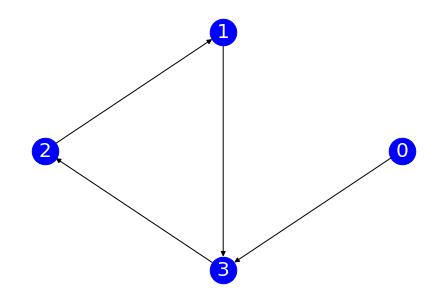

T2: a canonical weak tournament for 3 candidates: 


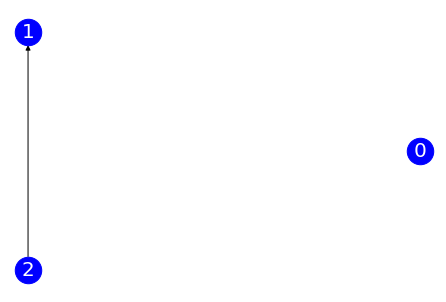

All the isomorphisms between the weak tournament T2 with 3 candidates and subgraphs of the weak tournament T1 with 4 candidates:

e(0) = 0, e(1) = 1, e(2) = 2
	This mapping is a tournament embedding

e(0) = 0, e(1) = 2, e(2) = 3
	There is an edge from 0 to 3 in T1
	But no edge from  0 to 2 in T2
	So this mapping is not a tournament embedding of T2 into T1

e(0) = 0, e(1) = 3, e(2) = 1
	There is an edge from 0 to 3 in T1
	But no edge from  0 to 1 in T2
	So this mapping is not a tournament embedding of T2 into T1

e(0) = 1, e(1) = 3, e(2) = 0
	There is an edge from 1 to 3 in T1
	But no edge from  0 to 1 in T2
	So this mapping is not a tournament embedding of T2 into T1



In [9]:
T1 = canonical_weak_tournaments[4][20]

print("T1: a canonical weak tournament for 4 candidates: ")
display_wt(T1)

print("T2: a canonical weak tournament for 3 candidates: ")
T2 = canonical_weak_tournaments[3][1]
display_wt(T2)

print("All the isomorphisms between the weak tournament T2 with 3 candidates and subgraphs of the weak tournament T1 with 4 candidates:\n")
for iso in nx.algorithms.isomorphism.GraphMatcher(T1, T2).subgraph_isomorphisms_iter():
    
    # iso is a dictionary mapping a subset of elements of the bigger graph T1 to the 
    # small graph T2, but it is easier to think about the inverse function mapping 
    # nodes in the small graph T2 into the bigger graph T1. 
    inverse_iso = {v:k for k,v in iso.items()}
    
    print(", ".join([f"e({c1}) = {c2}" for c1, c2 in inverse_iso.items()]))
    
    is_embedding = True
    for c1, c2 in product(T2.nodes, T2.nodes): 
        if T1.has_edge(inverse_iso[c1],inverse_iso[c2]) and not T2.has_edge(c1,c2):
            print(f"\tThere is an edge from {inverse_iso[c1]} to {inverse_iso[c2]} in T1")
            print(f"\tBut no edge from  {c1} to {c2} in T2")
            print("\tSo this mapping is not a tournament embedding of T2 into T1\n")
            is_embedding=False
    
    if is_embedding: 
        print("\tThis mapping is a tournament embedding\n")

To deal with this issue, we define a function which checks if a Networkx subgraph isomorphism is indeed a tournament embedding.

In [10]:
def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True    

### B. Generate canonical (weak) tournament embeddings

Find all canonical (weak) tournament embeddings from canonical (weak) tournaments of size $n$ into canonical (weak) tournaments of size $n+1$. 

In [11]:
def find_embeddings_g1_g2(g1, g2):
    embeddings = list()
    
    seen_ranges = set()

    for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1).subgraph_isomorphisms_iter():
        # for each isomporphism from g1 to a subgraph of g2

        # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
        # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
        # into the bigger graph g2:
        inverse_iso = {v:k for k,v in iso.items()}

        rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
        if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso): 
            # if haven't seen the range yet and g1 is an embedding into g2
            seen_ranges.add(rng)
            # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
            embeddings.append((g1, g2, inverse_iso))  
            
    return embeddings

In [12]:
def find_embeddings(min_num_cands, max_num_cands, canonical_graphs):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()
    
    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  
        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    
            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1
                embeddings += find_embeddings_g1_g2(g1, g2)

    return embeddings

In [13]:
def find_embeddings_2(max_num_cands, canonical_graphs):
    embeddings_2 = list()
    
    for g1 in canonical_graphs[2]:
        for nc in range(3, max_num_cands+1):
            for g2 in canonical_graphs[nc]:
                embeddings_2 += find_embeddings_g1_g2(g1, g2)
                
    return embeddings_2

## 5. Binary $\gamma$

In [14]:
def generate_bg_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wt_dictionary, 
                         possible_winners, 
                         embeddings,
                         embeddings_2): 
    """
    returns CNF clauses expressing binary gamma
    """

    C_bg = list()

    for nc in range(min_num_cands, max_num_cands+1):

        for t in canonical_graphs[nc]:
            # for each canonical graph on nc candidates
            
            E_t = [_emb for _emb in embeddings if _emb[1] == t]
            F_t = [_emb for _emb in embeddings_2 if _emb[1] == t]
            for emb in E_t: 
                # for each embedding into t from canonical graph emb[0]
                
                t_prime, _, e = emb 
                # t_prime is a canonical graph on nc-1 candidates, which t embeds into
                
                new_cand = list(set(t.nodes).difference(set(e.values())))[0]

                #new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t1 not in the range of the embedding from t_prime to t
                
                restricted_F_t = [_emb for _emb in F_t if new_cand in set(_emb[2].values())]
                
                for emb_2 in restricted_F_t:
                    # for each embedding into t from canonical 2-candidate graph emb_2[0]
                    
                    t_dblprime, _, f = emb_2
                    
                    a = list(set(e.values()).intersection(f.values()))[0]
                    
                    a_preimage_in_t_prime = [t_prime_cand for t_prime_cand, t_cand in e.items() 
                                             if t_cand == a][0]
                    a_preimage_in_t_dblprime = [t_dblprime_cand for t_dblprime_cand, t_cand in f.items()
                                             if t_cand == a][0]
                    
                    if (t_dblprime, tuple([a_preimage_in_t_dblprime])) in wt_dictionary:
                        A_t_dblprime = wt_dictionary[(t_dblprime, tuple([a_preimage_in_t_dblprime]))]

                        for A_t_prime in [wt_dictionary[t_prime, tuple(_ws)] 
                                          for _ws in powerset_ne_plus(t_prime.nodes, [a_preimage_in_t_prime])
                                          if (t_prime, tuple(_ws)) in wt_dictionary]:
                            clause = [-A_t_prime, -A_t_dblprime]
                            clause += [wt_dictionary[t, tuple(_ws)]
                                      for _ws in powerset_ne_plus(t.nodes, [a])
                                      if (t, tuple(_ws)) in wt_dictionary]

                            C_bg.append(clause)
                        
            
    return C_bg

## 6. $\alpha$-resoluteness

In [15]:
def generate_ar_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wt_dictionary, 
                         possible_winners, 
                         embeddings,
                         embeddings_2): 
    """
    returns CNF clauses expressing binary gamma
    """

    C_ar = list()

    for nc in range(min_num_cands, max_num_cands+1):

        for t in canonical_graphs[nc]:
            # for each canonical graph on nc candidates
            
            E_t = [_emb for _emb in embeddings if _emb[1] == t]
            F_t = [_emb for _emb in embeddings_2 if _emb[1] == t]
            for emb in E_t: 
                # for each embedding into t from canonical graph emb[0]
                
                t_prime, _, e = emb 
                # t_prime is a canonical graph on nc-1 candidates, which t embeds into
                
                new_cand = list(set(t.nodes).difference(set(e.values())))[0]

                #new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t1 not in the range of the embedding from t_prime to t
                
                restricted_F_t = [_emb for _emb in F_t if new_cand in set(_emb[2].values())]
                
                for emb_2 in restricted_F_t:
                    # for each embedding into t from canonical 2-candidate graph emb_2[0]
                    
                    t_dblprime, _, f = emb_2
                    
                    a = list(set(e.values()).intersection(f.values()))[0]
                    
                    a_preimage_in_t_prime = [t_prime_cand for t_prime_cand, t_cand in e.items() 
                                             if t_cand == a][0]
                    a_preimage_in_t_dblprime = [t_dblprime_cand for t_dblprime_cand, t_cand in f.items()
                                             if t_cand == a][0]
                    
                    if (t_dblprime, tuple([a_preimage_in_t_dblprime])) in wt_dictionary:
                        A_t_dblprime = wt_dictionary[(t_dblprime, tuple([a_preimage_in_t_dblprime]))]
                    
                        for ws_t_prime in [_ws for _ws in powerset_ne_plus(t_prime.nodes, [a_preimage_in_t_prime])
                                          if (t_prime, tuple(_ws)) in wt_dictionary]:
                            A_t_prime = wt_dictionary[t_prime, tuple(ws_t_prime)]
                            clause = [-A_t_prime, -A_t_dblprime]
                            clause += [wt_dictionary[(t, tuple(_ws))]
                                      for _ws in powerset_ne(t.nodes)
                                      if (t, tuple(_ws)) in wt_dictionary and len(_ws) <= len(ws_t_prime)]

                            C_ar.append(clause)
                        
            
    return C_ar

## 7. Demonstration of Theorem A.12

### A.  Demonstration of Theorem A.12.1

In [16]:
min_num_cands,max_num_cands = 2, 5

canonical_graphs = canonical_weak_tournaments
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
embeddings_2 = find_embeddings_2(max_num_cands, canonical_graphs)

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


In [17]:
C_bg = generate_bg_formula(min_num_cands, 
                             max_num_cands, 
                             canonical_graphs, 
                             wt_dictionary, 
                             possible_winners, 
                             embeddings,
                             embeddings_2
                            )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands, 
                             max_num_cands, 
                             canonical_graphs, 
                             wt_dictionary, 
                             possible_winners, 
                             embeddings,
                             embeddings_2
                            )
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [18]:
formula =  C_func + C_bg + C_ar + C_bqr
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weak tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")
else: 
    print(f"There is no canonical weak tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies BG, AR, and BQR.


In [19]:
formulas = {
    "AR": C_ar, 
    "BG": C_bg,
    "BQR": C_bqr
}

for fmls in powerset(formulas.keys()):
    
    formula =  concat([C_func] + [formulas[f] for f in fmls])
    sat_solver = Glucose3()
    for cl in formula:
        sat_solver.add_clause(cl)

    if sat_solver.solve(): 
        print(f"+ There is a canonical weak tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates{' that satisfies ' + ', '.join(fmls) + '.' if len(fmls) > 0 else '.'}\n")
    else: 
        print(f"- There is no canonical weak tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates{' that satisfies ' + ', '.join(fmls) + '.' if len(fmls) > 0 else '.'}\n")
    #vm = sat_solver.get_model()

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies AR.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies BG.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies BQR.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies AR, BG.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies AR, BQR.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies BG, BQR.

+ There is a canonical weak tournament solution, satisfying the orbit condition, up to 5 candidates that satisfies AR, BG, BQR.



### B.  Demonstration of Theorem A.12.2

Note that in this section, the SAT solver only considers formulas derived from canonical tournaments, as opposed to canonical weak tournaments.

In [20]:
min_num_cands,max_num_cands = 2, 6

canonical_graphs = canonical_tournaments
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
embeddings_2 = find_embeddings_2(max_num_cands, canonical_graphs)

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


In [21]:
C_bg = generate_bg_formula(min_num_cands, 
                             max_num_cands, 
                             canonical_graphs, 
                             wt_dictionary, 
                             possible_winners, 
                             embeddings,
                             embeddings_2
                            )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands, 
                             max_num_cands, 
                             canonical_graphs, 
                             wt_dictionary, 
                             possible_winners, 
                             embeddings,
                             embeddings_2
                            )
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [22]:
formula =  C_func + C_bg + C_ar + C_bqr
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")
else: 
    print(f"There is no canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is no canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BG, AR, and BQR.


In [23]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def concat(ls): 
    return list(chain.from_iterable(ls))

formulas = {
    "AR": C_ar, 
    "BG": C_bg,
    "BQR": C_bqr
}

for fmls in powerset(formulas.keys()):
    
    formula =  concat([C_func] + [formulas[f] for f in fmls])
    sat_solver = Glucose3()
    for cl in formula:
        sat_solver.add_clause(cl)

    if sat_solver.solve(): 
        print(f"+ There is a canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates{' that satisfies ' + ', '.join(fmls) + '.' if len(fmls) > 0 else '.'}\n")
    else: 
        print(f"- There is no canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates{' that satisfies ' + ', '.join(fmls) + '.' if len(fmls) > 0 else '.'}\n")
    #vm = sat_solver.get_model()

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies AR.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BG.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BQR.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies AR, BG.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies AR, BQR.

+ There is a canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BG, BQR.

- There is no canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies AR, BG, BQR.

